# Predicting Waiting Time in Banks Using Machine Learning

## Project Overview
The project's goal is to predict the waiting time of new customers in banks using machine learning methods. The primary objective is to forecast the waiting time based on the customer's arrival time and the current number of people in the queue.

## Key Stages

### 1. Data Collection and Processing
- Data was collected from three banks over four weeks.
- Each file contains information about customer arrival time, waiting time, and service time.

### 2. Data Exploration
- Key statistical indicators, such as average waiting time and the number of people in the queue, were calculated.
- Histograms and normal distributions were created to analyze probability density functions.

### 3. Data Preparation
- Input data (hours, minutes, day of the week) was encoded using mean encoding techniques for regression.
- The data was split into training and testing sets.
- Feature standardization was performed.

### 4. Theoretical Foundation: Queueing Theory (QMS)
- To better understand the waiting process, the concept of **Queueing Management Systems (QMS)** was used.
- QMS describes systems where customers (e.g., bank visitors) require service, and service facilities (e.g., tellers or managers) provide that service.
- The **M/M/1 model** was used, which assumes a single queue and one service facility with exponentially distributed inter-arrival and service times.
- Key model parameters:
  - **λ (lambda)** — the arrival rate (average number of customers per unit of time).
  - **μ (mu)** — the service rate (average number of customers served per unit of time).
  - **ρ (rho)** — the system's utilization factor, calculated as ρ = λ / μ.
- The model allows the estimation of the average waiting time in the queue and the number of customers in the system, which is then used in machine learning to enhance prediction accuracy.

### 5. Model Development
- A neural network with two hidden layers was developed and trained to predict waiting times.
- The model was trained over 500 epochs using the Keras and TensorFlow libraries.

### 6. Model Evaluation
- During training, the model demonstrated decreasing loss on the validation set, indicating improved prediction accuracy.

## Results
The model achieved minimal loss values on the test set, confirming its ability to accurately predict customer waiting times based on their arrival time and the current workload of the bank.


In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import os
import openpyxl as opx

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Input

# Loading Data from Dataset

The data was processed to record the arrival time, the time spent in the queue, and the service time of the client in the bank.

In [2]:
def file_len(fname, dayCounter):
    workbook = opx.load_workbook(fname, data_only=True)
    sheet = workbook.worksheets[dayCounter]
    return sheet.max_row

def file_read(path, numberOfRows, dayCounter):
    indexCounter = 0
    workbook = opx.load_workbook(path)
    sheet = workbook.worksheets[dayCounter]
    nColumns = 4  # количество столбцов: час, минуты, ожидание, обслуживание
    dataset = np.zeros(shape = (numberOfRows, nColumns))
    arrivalTimes = []
    flag = 1
    for row in sheet.iter_rows(min_row=2, max_row=numberOfRows+1, values_only=True):
        try:
            arrivalTime = row[1]  # Время прибытия во втором столбце
            arrivalHour = arrivalTime.hour
            arrivalMinute = arrivalTime.minute
            waitingMinutes = row[2]  # X1 в третьем столбце
            serviceMinutes = row[3]  # X2 в четвертом столбце
        
            arrivalTimes.append(arrivalTime)
            dataset[indexCounter] = [arrivalHour, arrivalMinute, waitingMinutes, serviceMinutes]
            indexCounter += 1
        except Exception as e:
            print(f"Ошибка обработки строки {indexCounter + 1}: {e}")
            if indexCounter > 0:
                dataset[indexCounter] = dataset[indexCounter - 1]
            indexCounter += 1
    return dataset, arrivalTimes

filenames = []
rootFilePath = './BankData/'
fullDataset = pd.DataFrame()

for bankCounter in range(1, 13):  # 12 файлов для каждого банка
    for dayCounter in range(5):  # 5 дней в неделе
        filename = 'Sber' + str(bankCounter)
        fullPath = rootFilePath + filename + '.xlsx'
        filenames.append(fullPath)

        numberOfRows = file_len(fullPath, dayCounter) - 1
        print(f'Чтение {filename}.xlsx. День {dayCounter + 1}. Файл содержит {numberOfRows} строк')
        tempFeatures, tempArrivalTimes = file_read(fullPath, numberOfRows, dayCounter)
        
        dfTempFeatures = pd.DataFrame(np.array(tempFeatures), columns=['hour', 'minutes', 'waitingTime', 'serviceTime'])
        dfTempArrivalTimes = pd.DataFrame(np.array(tempArrivalTimes), columns=['arrivalTime'])

        timeLeavingTheQueue = []
        timeLeavingTheSystem = []
        for arrivalTimeCounter in range(numberOfRows):
            using_time = dfTempArrivalTimes.at[arrivalTimeCounter, 'arrivalTime']
            using_minute = dfTempFeatures.at[arrivalTimeCounter, 'waitingTime']
            using_minute_service = dfTempFeatures.at[arrivalTimeCounter, 'serviceTime']
            
            leaving_time_minute_step1 = using_time.minute + using_minute
            leaving_time_hour_step1 = using_time.hour
            if leaving_time_minute_step1 >= 60:
                leaving_time_minute_step1 = leaving_time_minute_step1 - 60
                leaving_time_hour_step1 = leaving_time_hour_step1 + 1
            leaving_time_minute = 0
            leaving_time_hour = 0
            if type(leaving_time_minute_step1) == int:
                leaving_time_minute = leaving_time_minute_step1
            else:
                leaving_time_minute = leaving_time_minute_step1.astype(int)

            if type(leaving_time_hour_step1) == int:
                leaving_time_hour = leaving_time_hour_step1
            else:
                leaving_time_hour = leaving_time_hour_step1.astype(int)
            
            leaving_the_system_time_minute_step1 = leaving_time_minute + using_minute_service
            leaving_the_system_time_hour = leaving_time_hour
            
            if leaving_the_system_time_minute_step1 >= 60:
                leaving_the_system_time_minute_step1 = leaving_the_system_time_minute_step1 - 60
                leaving_the_system_time_hour = leaving_the_system_time_hour + 1
            
            if type(leaving_the_system_time_minute_step1) == int:
                leaving_the_system_time_minute = leaving_the_system_time_minute_step1
            else:
                leaving_the_system_time_minute = leaving_the_system_time_minute_step1.astype(int)

            timeLeavingTheQueue.append(dt.time(hour = leaving_time_hour, minute = leaving_time_minute.astype(int)))
            timeLeavingTheSystem.append(dt.time(hour = leaving_the_system_time_hour, minute = leaving_the_system_time_minute))

        dftimeLeavingTheQueue = pd.DataFrame(np.array(timeLeavingTheQueue), columns=['timeLeavingTheQueue'])
        dftimeLeavingTheSystem = pd.DataFrame(np.array(timeLeavingTheSystem), columns=['timeLeavingTheSystem'])

        waitingPeople = np.zeros(numberOfRows)
        inSystemPeople = np.zeros(numberOfRows)
        servicePeople = np.zeros(numberOfRows)
        for i in range(numberOfRows):
            for j in range(i):
                if (dfTempArrivalTimes.at[i, 'arrivalTime'] < dftimeLeavingTheQueue.at[j, 'timeLeavingTheQueue']):
                    waitingPeople[i] += 1
                if (dfTempArrivalTimes.at[i, 'arrivalTime'] < dftimeLeavingTheSystem.at[j, 'timeLeavingTheSystem']):
                    inSystemPeople[i] += 1
            servicePeople[i] = inSystemPeople[i] - waitingPeople[i]
        dfWaitingPeople = pd.DataFrame(np.array(waitingPeople), columns=['waitingPeople'])
        dfInSystemPeople = pd.DataFrame(np.array(inSystemPeople), columns=['inSystemPeople'])
        dfServicePeople = pd.DataFrame(np.array(servicePeople), columns=['servicePeople'])

        dayOfWeek = np.zeros(numberOfRows)
        for i in range(numberOfRows):
            dayOfWeek[i] = dayCounter
        dfDayOfWeek = pd.DataFrame(np.array(dayOfWeek), columns=['dayOfWeek'])

        dfWaitingPeople['waitingPeople'] = dfWaitingPeople['waitingPeople'].astype(int)
        dfTempFeatures['hour'] = dfTempFeatures['hour'].astype(int)
        dfTempFeatures['minutes'] = dfTempFeatures['minutes'].astype(int)
        dfDayOfWeek['dayOfWeek'] = dfDayOfWeek['dayOfWeek'].astype(int)
        dfInSystemPeople['inSystemPeople'] = dfInSystemPeople['inSystemPeople'].astype(int)
        dfServicePeople['servicePeople'] = dfServicePeople['servicePeople'].astype(int)

        tempDataset = pd.concat([dfTempFeatures, dfWaitingPeople, dfServicePeople, dfInSystemPeople, dfDayOfWeek], axis=1)

        fullDataset = pd.concat([fullDataset, tempDataset], axis=0)
          
fullDataset = fullDataset.reset_index(drop = True)
print(f'Датасет: {fullDataset.shape[0]} строк и {fullDataset.shape[1]} колонок')

Чтение Sber1.xlsx. День 1. Файл содержит 880 строк
Чтение Sber1.xlsx. День 2. Файл содержит 851 строк
Чтение Sber1.xlsx. День 3. Файл содержит 1020 строк
Чтение Sber1.xlsx. День 4. Файл содержит 802 строк
Чтение Sber1.xlsx. День 5. Файл содержит 522 строк
Чтение Sber2.xlsx. День 1. Файл содержит 989 строк
Чтение Sber2.xlsx. День 2. Файл содержит 684 строк
Чтение Sber2.xlsx. День 3. Файл содержит 548 строк
Чтение Sber2.xlsx. День 4. Файл содержит 1021 строк
Чтение Sber2.xlsx. День 5. Файл содержит 789 строк
Чтение Sber3.xlsx. День 1. Файл содержит 1000 строк
Чтение Sber3.xlsx. День 2. Файл содержит 990 строк
Чтение Sber3.xlsx. День 3. Файл содержит 1001 строк
Чтение Sber3.xlsx. День 4. Файл содержит 1051 строк
Чтение Sber3.xlsx. День 5. Файл содержит 982 строк
Чтение Sber4.xlsx. День 1. Файл содержит 857 строк
Чтение Sber4.xlsx. День 2. Файл содержит 981 строк
Чтение Sber4.xlsx. День 3. Файл содержит 1057 строк
Чтение Sber4.xlsx. День 4. Файл содержит 899 строк
Чтение Sber4.xlsx. День 5

In [3]:
fullDataset.head(50)

,hour,minutes,waitingTime,serviceTime,waitingPeople,servicePeople,inSystemPeople,dayOfWeek
0,10,0,11.0,28.0,0,0,0,0
1,10,0,13.0,25.0,1,0,1,0
2,10,0,14.0,26.0,2,0,2,0
3,10,0,9.0,26.0,3,0,3,0
4,10,0,14.0,23.0,4,0,4,0
5,10,0,10.0,26.0,5,0,5,0
6,10,0,9.0,27.0,6,0,6,0
7,10,1,10.0,27.0,7,0,7,0
8,10,1,11.0,26.0,8,0,8,0
9,10,1,12.0,24.0,9,0,9,0


In [4]:
fullDataset.describe()

,hour,minutes,waitingTime,serviceTime,waitingPeople,servicePeople,inSystemPeople,dayOfWeek
count,52636.000000,52636.000000,52636.000000,52636.000000,52636.000000,52636.000000,52636.000000,52636.000000
mean,12.684550,27.828444,13.453235,13.439512,28.995896,28.189167,57.185063,1.954214
std,2.154595,17.421315,6.052131,5.911448,17.810898,19.157396,28.201847,1.408787
min,10.000000,0.000000,3.004883,4.000488,0.000000,0.000000,0.000000,0.000000
25%,11.000000,13.000000,9.077013,8.740287,17.000000,15.000000,36.000000,1.000000
50%,12.000000,27.000000,12.063906,12.301431,25.000000,24.000000,53.000000,2.000000
75%,15.000000,43.000000,16.731613,17.114917,37.000000,38.000000,75.000000,3.000000
max,16.000000,59.000000,34.984741,35.999512,109.000000,134.000000,164.000000,4.000000


# Исследование данных

## Время ожидания людей и количество людей в очереди

In [5]:
n = 'undefined' #число каналов в СМО

numberOfBanks = 12
numberOfDays = 5
numberOfHours = 7
lamb = fullDataset.shape[0]/numberOfBanks/numberOfDays/numberOfHours #интенсивность поступления в СМО заявок
print(f'Интенсивность поступления заявок в СМО: {lamb} заявок/час')

mu = lamb #интенсивность обслуживания заявок = интенсивности поступления, учитывая
#то, что для каждой заявки указано время ожидания. В противном случае, эту информацию взять неоткуда
print(f'Интенсивность обслуживания заявок: {mu} заявок/час (равна интенсивности поступления, так как информации об уходящих нет)')

ro = lamb/mu #коэффициент загрузки СМО
print(f'Коэффициент загрузки СМО: {ro}')

m = 9999 #число мест в очереди в данной задаче не имеет особого смысла

pOtk = 0. #вероятность отказа в обслуживании
print(f'Вероятность отказа в обслуживании: {pOtk}')

pObs = 1. - pOtk #вероятность обслуживания
print(f'Вероятность обслуживания поступившей заявки: {pObs}\n')

A = lamb * pObs #среднее число заявок, которое СМО обслуживает в единицу времени
#(абсолютная пропускная способность)
print(f'Среднее число обслуживаемых заявок: {A} заявок/час')

meanLSMO = fullDataset['inSystemPeople'].mean() #среднее число заявок, находящихся в СМО
print(f'Среднее число заявок в СМО: {meanLSMO}')
medianLSMO = fullDataset['inSystemPeople'].median()
print(f'Медианное число завявок в СМО: {medianLSMO}')
stdLSMO = fullDataset['inSystemPeople'].std()
print(f'Среднеквадратичное отклонение числа заявок в СМО: {stdLSMO}\n')

meanWaiting = fullDataset['waitingPeople'].mean() #среднее число заявок в очереди
print(f'Среднее число заявок в очереди: {meanWaiting}')
medianWaiting = fullDataset['waitingPeople'].median()
print(f'Медианное число заявок в очереди: {medianWaiting}')
stdWaiting = fullDataset['waitingPeople'].std()
print(f'Среднеквадратичное отклонение числа заявок в очереди: {stdWaiting}\n')

meanChannels = fullDataset['servicePeople'].mean() #/numberOfRows #среднее число каналов, занятых обслуживанием
print(f'Среднее число каналов, занятых обслуживанием: {meanChannels}')
medianChannels = fullDataset['servicePeople'].median()
print(f'Медианное число каналов, занятых обслуживанием: {medianChannels}')
stdChannels = fullDataset['servicePeople'].std()
print(f'Среднеквадратичное отклонение каналов, занятых обслуживанием: {stdChannels}\n')

#коэффициент занятости каналов не посчитать

#интенсивность потока ухода заявок из очереди не посчитать

myMean = fullDataset["waitingTime"].mean()
print(f'Среднее время ожидания в очереди: {myMean} минут')

myMedian = fullDataset["waitingTime"].median()
print(f'Медианное время ожидания в очереди: {myMedian} минут')

myStd = fullDataset["waitingTime"].std()
print(f'Среднеквадратичное отклонение времени ожидания в очереди: {myStd} минут.\n')

Интенсивность поступления заявок в СМО: 125.32380952380952 заявок/час
Интенсивность обслуживания заявок: 125.32380952380952 заявок/час (равна интенсивности поступления, так как информации об уходящих нет)
Коэффициент загрузки СМО: 1.0
Вероятность отказа в обслуживании: 0.0
Вероятность обслуживания поступившей заявки: 1.0

Среднее число обслуживаемых заявок: 125.32380952380952 заявок/час
Среднее число заявок в СМО: 57.18506345466981
Медианное число завявок в СМО: 53.0
Среднеквадратичное отклонение числа заявок в СМО: 28.201846894661625

Среднее число заявок в очереди: 28.995896344707045
Медианное число заявок в очереди: 25.0
Среднеквадратичное отклонение числа заявок в очереди: 17.810898386437785

Среднее число каналов, занятых обслуживанием: 28.189167109962764
Медианное число каналов, занятых обслуживанием: 24.0
Среднеквадратичное отклонение каналов, занятых обслуживанием: 19.157396023994977

Среднее время ожидания в очереди: 13.453234944958249 минут
Медианное время ожидания в очереди:

## Построение гистограммы и нормального распределения

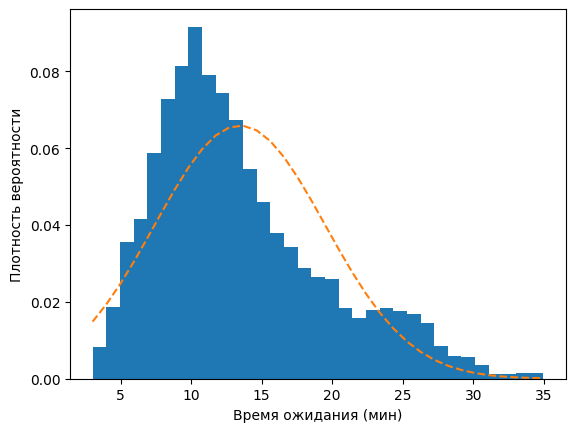

In [6]:
mean = fullDataset["waitingTime"].mean()  # среднее значение времени ожидания в очереди
sigma = fullDataset["waitingTime"].std()  # среднеквадратичное отклонение времени ожидания в очереди
x = fullDataset["waitingTime"]

num_bins = 33

fig, ax = plt.subplots() #формируем объекты поля рисования и его настройки

n, bins, patches = ax.hist(x, num_bins, density=1) #строим гистограму плотности вероятности

y = ((1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-0.5 * (1 / sigma * (bins - mean))**2))

ax.plot(bins, y, '--')
ax.set_xlabel('Время ожидания (мин)')
ax.set_ylabel('Плотность вероятности')

os.makedirs('./plots', exist_ok=True)

plt.savefig('./plots/waitingTimeHistogram.pdf')

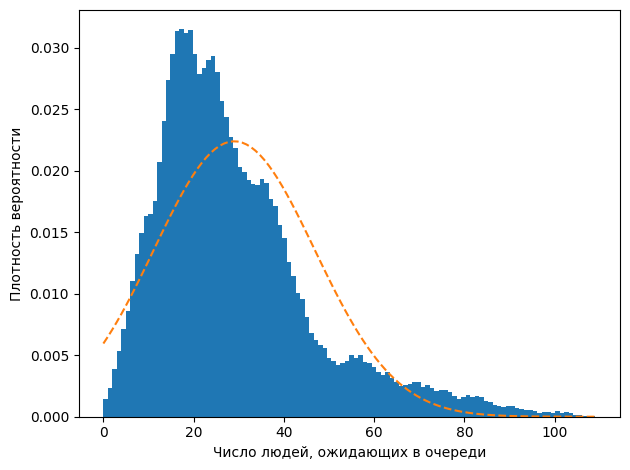

In [7]:
mean = fullDataset["waitingPeople"].mean()  #среднее число ожидающих своей очереди заявок
sigma = fullDataset["waitingPeople"].std()  #среднеквадратичное отклонение ожидающих своей очереди заявок
x = fullDataset["waitingPeople"]

num_bins = 110
fig, ax = plt.subplots() #формируем объекты поля рисования и его настройки

n, bins, patches = ax.hist(x, num_bins, density=1) #строим гистограму плотности вероятности (density = 1)

y = ((1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-0.5 * (1 / sigma * (bins - mean))**2))

ax.plot(bins, y, '--')
ax.set_xlabel('Число людей, ожидающих в очереди')
ax.set_ylabel('Плотность вероятности')

fig.tight_layout()
plt.savefig('./plots/waitingPeopleHistogram.pdf')

# Подготовка данных для обучения нейронной сети

In [8]:
def mean_encoder_regression(input_vector, output_vector):
    assert len(input_vector) == len(output_vector)
    numberOfRows = len(input_vector)

    temp = pd.concat([input_vector, output_vector], axis=1)
    averages = temp.groupby(by=input_vector.name)[output_vector.name].agg(["mean", "count"])
    
    print(averages)
    return_vector = pd.DataFrame(0, index=np.arange(numberOfRows), columns=['feature'], dtype='float64')

    
    for i in range(numberOfRows):
        return_vector.iloc[i] = averages['mean'][input_vector.iloc[i]]
        
    return return_vector

In [9]:
workingCopyDataset = fullDataset
workingCopyDataset.drop(['serviceTime'], axis=1);

In [10]:
encoded_input_vector_hour = mean_encoder_regression(workingCopyDataset['hour'], workingCopyDataset['waitingTime'])
encoded_input_vector_hour.columns = ['hour']
encoded_input_vector_minutes = mean_encoder_regression(workingCopyDataset['minutes'], workingCopyDataset['waitingTime'])
encoded_input_vector_minutes.columns = ['minutes']
encoded_input_vector_dayOfWeek = mean_encoder_regression(workingCopyDataset['dayOfWeek'], workingCopyDataset['waitingTime'])
encoded_input_vector_dayOfWeek.columns = ['dayOfWeek']

           mean  count
hour                  
10    13.275502  11811
11    13.453828   8682
12    13.165451   6076
13    13.624776   5840
14    13.319474   6249
15    13.301795   5914
16    14.020238   8064
              mean  count
minutes                  
0        13.351721   1261
1        13.572363   1294
2        13.490881    881
3        13.543680    991
4        13.925891    929
5        13.283427   1138
6        13.342000    689
7        13.588167   1055
8        13.150438    823
9        13.554988    852
10       13.346630    851
11       13.532739   1190
12       13.593176    786
13       13.378263    876
14       13.673422    826
15       13.602620   1154
16       13.638419    860
17       13.749430   1232
18       13.742317    763
19       13.582883   1329
20       13.461401   1026
21       13.715065    885
22       14.247538    661
23       13.136453   1096
24       13.740649    800
25       13.275089   1131
26       13.819093    822
27       13.421109    977
28       13.8

In [11]:
X = pd.concat([encoded_input_vector_hour['hour'], encoded_input_vector_minutes['minutes'], pd.DataFrame(workingCopyDataset['waitingPeople']), encoded_input_vector_dayOfWeek['dayOfWeek']], axis=1)
y = workingCopyDataset['waitingTime']

In [12]:
X.describe()

,hour,minutes,waitingPeople,dayOfWeek
count,52636.000000,52636.000000,52636.000000,52636.000000
mean,13.453235,13.453235,28.995896,13.453235
std,0.271789,0.315181,17.810898,0.624008
min,13.165451,12.752886,0.000000,12.812132
25%,13.275502,13.223652,17.000000,12.891973
50%,13.319474,13.461401,25.000000,13.095238
75%,13.624776,13.638419,37.000000,14.076962
max,14.020238,14.251291,109.000000,14.283216


## Используем sklearn для машинного обучения

In [13]:
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.2, random_state=42)
print(trainX.shape, trainy.shape)
print(testX.shape, testy.shape)

(42108, 4) (42108,)
(10528, 4) (10528,)


In [14]:
def scale_input(X, means, stds):
    return (X - means) / stds

def descale_input(X, means, stds):
    return (X * stds) + means

In [15]:
meansX = trainX.mean(axis=0)
stdsX = trainX.std(axis=0) + 1e-10

In [16]:
trainX_scaled = scale_input(trainX, meansX, stdsX)
testX_scaled = scale_input(testX, meansX, stdsX)

# Нейронная сеть

## Создание модели Deep Learning с двумя слоями

In [17]:
inputVariables = 4

model = Sequential()
model.add(Input(shape=(inputVariables,)))
model.add(keras.layers.Dense(10, kernel_initializer='normal', activation='relu'))
model.add(keras.layers.Dense(10, activation='relu'))
model.add(keras.layers.Dense(1, activation='relu'))

model.summary()

model.compile(loss='mae', optimizer='adam')

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 10)                  │              50 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             110 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 171 (684.00 B)

 Trainable params: 171 (684.00 B)

 Non-trainable params: 0 (0.00 B)

## Обучение нейронной сети

In [18]:
numberOfEpochs = 500
batchSize = 128
history = model.fit(trainX_scaled, trainy, epochs=numberOfEpochs, batch_size=batchSize, verbose=1, validation_split=0.2)

Epoch 1/500
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 12.2775 - val_loss: 6.3868
Epoch 2/500
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step - loss: 5.0300 - val_loss: 3.6771
Epoch 3/500
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.6915 - val_loss: 3.6225
Epoch 4/500
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step - loss: 3.6449 - val_loss: 3.5967
Epoch 5/500
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step - loss: 3.6449 - val_loss: 3.5848
Epoch 6/500
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step - loss: 3.6422 - val_loss: 3.5687
Epoch 7/500
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step - loss: 3.6181 - val_loss: 3.5605
Epoch 8/500
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.6059 - val_loss: 3.5600
Epoch 9/500
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.5892 - val_loss: 3.5423
Epoch 10/500
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.5979 - val_loss: 3.5390
Epoch 11/500
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step - loss: 3.5904 - val_loss: 3.5363
Epoch 12/500
264/264 ━━━━━━━

33686/33686 [==============================] - 0s 9us/sample - loss: 3.3848 - val_loss: 3.3342
Epoch 451/500
33686/33686 [==============================] - 0s 9us/sample - loss: 3.3833 - val_loss: 3.3426
Epoch 452/500
33686/33686 [==============================] - 0s 8us/sample - loss: 3.3855 - val_loss: 3.3393
Epoch 453/500
33686/33686 [==============================] - 0s 8us/sample - loss: 3.3855 - val_loss: 3.3433
Epoch 454/500
33686/33686 [==============================] - 0s 8us/sample - loss: 3.3844 - val_loss: 3.3344
Epoch 455/500
33686/33686 [==============================] - 0s 8us/sample - loss: 3.3826 - val_loss: 3.3428
Epoch 456/500
33686/33686 [==============================] - 0s 8us/sample - loss: 3.3845 - val_loss: 3.3305
Epoch 457/500
33686/33686 [==============================] - 0s 8us/sample - loss: 3.3859 - val_loss: 3.3429
Epoch 458/500
33686/33686 [==============================] - 0s 8us/sample - loss: 3.3836 - val_loss: 3.3257
Epoch 459/500
33686/33686 [======

## Погрешность нейронной сети

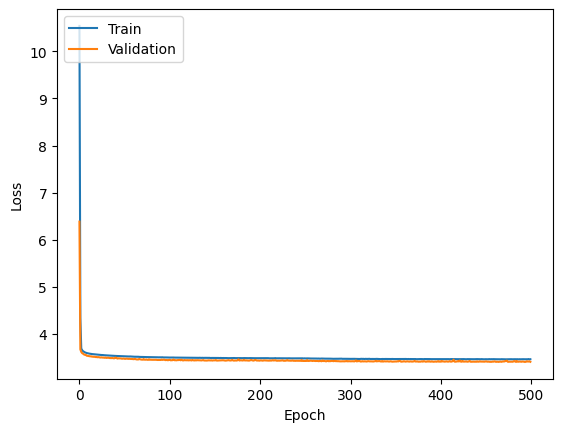

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.savefig('./plots/loss.pdf')

329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 633us/step


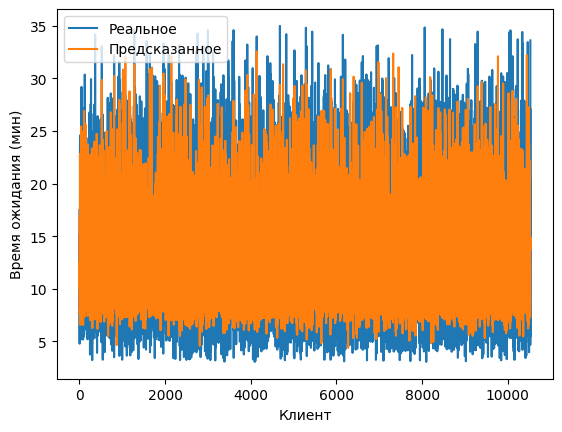

In [20]:
testy_pred = model.predict(testX_scaled)
myLength = len(testy_pred)
plt.plot(range(myLength), testy)
plt.plot(range(myLength), testy_pred)
plt.ylabel('Время ожидания (мин)')
plt.xlabel('Клиент')
plt.legend(['Реальное', 'Предсказанное'], loc='upper left')
plt.savefig('./plots/realVsPredictedWaitingTimes.pdf')

## Сравнение нейронной сети со средним и медианным значениями

In [21]:
myMae = mean_absolute_error(testy, testy_pred)
print(f'Средняя абсолютная ошибка нейронной сети: {myMae} минуты.')

Средняя абсолютная ошибка нейронной сети: 3.398501276699096 минуты.


In [22]:
myLength = len(testy_pred)
myFMean = np.mean(trainy)
myFMedian = np.median(trainy)
testyMean = testy_pred.copy()
testyMedian = testy_pred.copy()
for i in range(myLength):
    testyMean[i] = myFMean
    testyMedian[i] = myFMedian

In [23]:
meanValue = mean_absolute_error(testy, testyMean)
print(f'Средняя абсолютная ошибка, полученная с помощью аппроксимации средним значением: {meanValue} минут.')

Средняя абсолютная ошибка, полученная с помощью аппроксимации средним значением: 4.771244205909666 минут.


In [24]:
medianValue = mean_absolute_error(testy, testyMedian)
print(f'Средняя абсолютная ошибка, полученная с помощью аппроксимации медианным значением: {medianValue} минут.')

Средняя абсолютная ошибка, полученная с помощью аппроксимации медианным значением: 4.634170441058564 минут.
